# Perceptron with PyTorch: High-Level Neural Network Framework

In this notebook, we'll implement a perceptron using PyTorch, showcasing the powerful abstractions that modern deep learning frameworks provide.

## Comparison with NumPy Implementation

**What PyTorch gives us:**
- ✅ Automatic differentiation (autograd)
- ✅ Built-in optimizers (SGD, Adam, etc.)
- ✅ GPU acceleration with minimal code changes
- ✅ Pre-built loss functions
- ✅ Model serialization/loading
- ✅ Seamless integration with complex architectures

**Learning Objectives:**
1. Understand PyTorch tensors and autograd
2. Implement perceptrons using `nn.Module`
3. Use built-in optimizers and loss functions
4. Compare performance and simplicity with NumPy
5. Scale to more complex problems effortlessly

## 0. GPU Setup

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 1. PyTorch Setup and Basics

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Using device: cuda
PyTorch version: 2.6.0+cu124


## 2. PyTorch Tensors vs NumPy Arrays

In [3]:
# Compare NumPy arrays and PyTorch tensors
print("NumPy vs PyTorch comparison:")
print("=" * 40)

# NumPy array
np_array = np.array([[1, 2], [3, 4]], dtype=np.float32)
print(f"NumPy array:\n{np_array}")
print(f"Type: {type(np_array)}")

# Convert to PyTorch tensor
torch_tensor = torch.from_numpy(np_array)
print(f"\nPyTorch tensor:\n{torch_tensor}")
print(f"Type: {type(torch_tensor)}")
print(f"Device: {torch_tensor.device}")
print(f"Requires grad: {torch_tensor.requires_grad}")

# Enable gradient computation
torch_tensor.requires_grad_(True)
print(f"After enabling grad: {torch_tensor.requires_grad}")

# Demonstrate automatic differentiation
print("\nAutomatic differentiation demo:")
x = torch.tensor([1.0, 2.0], requires_grad=True)
y = x ** 2
z = y.sum()

print(f"x = {x}")
print(f"y = x² = {y}")
print(f"z = sum(y) = {z}")

# Backpropagation
z.backward()
print(f"dz/dx = {x.grad}")
print("Expected: [2*1, 2*2] = [2, 4] ✓")

NumPy vs PyTorch comparison:
NumPy array:
[[1. 2.]
 [3. 4.]]
Type: <class 'numpy.ndarray'>

PyTorch tensor:
tensor([[1., 2.],
        [3., 4.]])
Type: <class 'torch.Tensor'>
Device: cpu
Requires grad: False
After enabling grad: True

Automatic differentiation demo:
x = tensor([1., 2.], requires_grad=True)
y = x² = tensor([1., 4.], grad_fn=<PowBackward0>)
z = sum(y) = 5.0
dz/dx = tensor([2., 4.])
Expected: [2*1, 2*2] = [2, 4] ✓


## 3. Simple Perceptron Implementation

In [4]:
class SimplePerceptron(nn.Module):
    def __init__(self, input_size):
        super(SimplePerceptron, self).__init__()
        # Single linear layer (this includes both weights and bias!)
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        # Forward pass through linear layer
        return self.linear(x)

# Create perceptron
perceptron = SimplePerceptron(input_size=2)
print("Simple Perceptron created!")
print(f"Parameters: {sum(p.numel() for p in perceptron.parameters())}")

# Inspect the parameters
for name, param in perceptron.named_parameters():
    print(f"{name}: shape {param.shape}, values {param.data}")

# Test forward pass
test_input = torch.tensor([[1.0, 2.0]])
output = perceptron(test_input)
print(f"\nTest input: {test_input}")
print(f"Output: {output}")

Simple Perceptron created!
Parameters: 3
linear.weight: shape torch.Size([1, 2]), values tensor([[0.5406, 0.5869]])
linear.bias: shape torch.Size([1]), values tensor([-0.1657])

Test input: tensor([[1., 2.]])
Output: tensor([[1.5488]], grad_fn=<AddmmBackward0>)


## 4. Training on Logic Gates with PyTorch

AND Gate Data:
Inputs:
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
Labels:
tensor([[0.],
        [0.],
        [0.],
        [1.]])

Model: SimplePerceptron(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Loss function: BCEWithLogitsLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Training...
Epoch [20/100], Loss: 0.6138
Epoch [40/100], Loss: 0.5504
Epoch [60/100], Loss: 0.5109
Epoch [80/100], Loss: 0.4795
Epoch [100/100], Loss: 0.4526

Testing trained model:
Input: [0. 0.], Expected: 0, Predicted: 0, Probability: 0.210
Input: [0. 1.], Expected: 0, Predicted: 0, Probability: 0.274
Input: [1. 0.], Expected: 0, Predicted: 0, Probability: 0.372
Input: [1. 1.], Expected: 1, Predicted: 0, Probability: 0.456


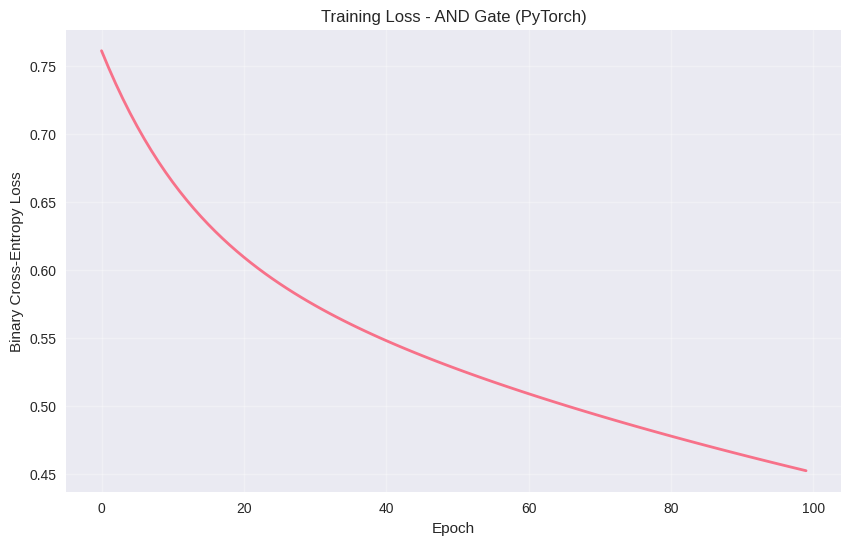

In [5]:
# Prepare AND gate data
X_and = torch.tensor([[0.0, 0.0],
                      [0.0, 1.0],
                      [1.0, 0.0],
                      [1.0, 1.0]])

y_and = torch.tensor([[0.0], [0.0], [0.0], [1.0]])

print("AND Gate Data:")
print(f"Inputs:\n{X_and}")
print(f"Labels:\n{y_and}")

# Create model, loss function, and optimizer
model = SimplePerceptron(input_size=2)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.SGD(model.parameters(), lr=0.1)

print(f"\nModel: {model}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

# Training loop
num_epochs = 100
losses = []

print("\nTraining...")
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_and)
    loss = criterion(outputs, y_and)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights

    # Record loss
    losses.append(loss.item())

    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the trained model
print("\nTesting trained model:")
with torch.no_grad():  # No need to compute gradients for testing
    test_outputs = model(X_and)
    predictions = torch.sigmoid(test_outputs) > 0.5

    for i in range(len(X_and)):
        print(f"Input: {X_and[i].numpy()}, Expected: {y_and[i].item():.0f}, "
              f"Predicted: {predictions[i].item():.0f}, "
              f"Probability: {torch.sigmoid(test_outputs[i]).item():.3f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, linewidth=2)
plt.title('Training Loss - AND Gate (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 5. Advanced Perceptron with Different Activations

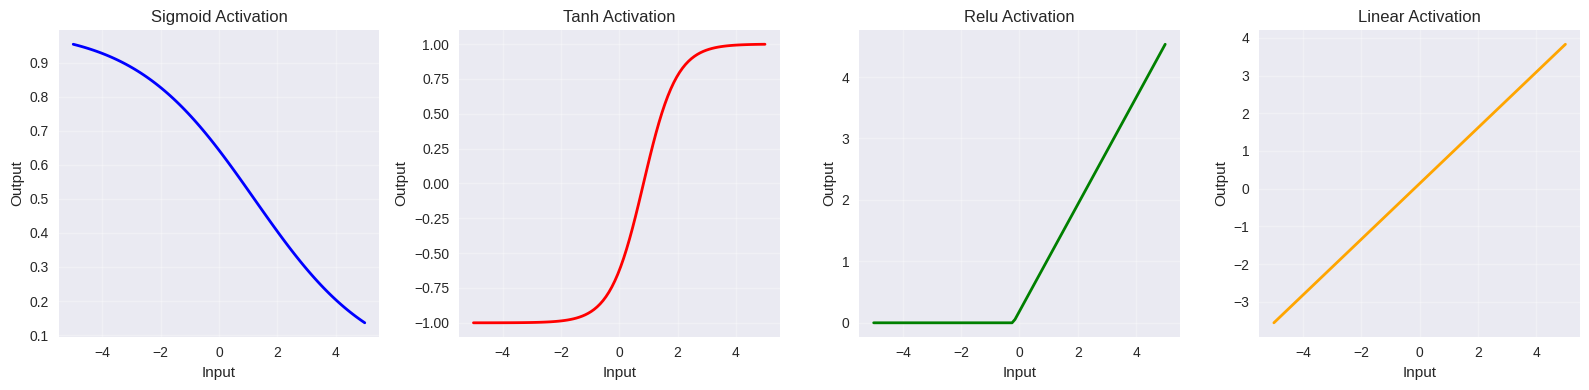

In [8]:
class AdvancedPerceptron(nn.Module):
    def __init__(self, input_size, activation='sigmoid'):
        super(AdvancedPerceptron, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.activation = activation

    def forward(self, x):
        x = self.linear(x)

        if self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'relu':
            return torch.relu(x)
        else:
            return x  # Linear output

# Test different activation functions
activations = ['sigmoid', 'tanh', 'relu', 'linear']
colors = ['blue', 'red', 'green', 'orange']

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (activation, color) in enumerate(zip(activations, colors)):
    # Create model
    model = AdvancedPerceptron(input_size=1, activation=activation)

    # Test with a range of inputs
    x_test = torch.linspace(-5, 5, 100).unsqueeze(1)

    with torch.no_grad():
        y_test = model(x_test)

    # Plot
    axes[i].plot(x_test.numpy(), y_test.numpy(), color=color, linewidth=2)
    axes[i].set_title(f'{activation.title()} Activation')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlabel('Input')
    axes[i].set_ylabel('Output')

plt.tight_layout()
plt.show()

## 6. Multiple Logic Gates with Batch Training


Training AND gate...
  Final accuracy: 100.0%

Training OR gate...
  Final accuracy: 100.0%

Training NAND gate...
  Final accuracy: 100.0%

Training NOR gate...
  Final accuracy: 100.0%


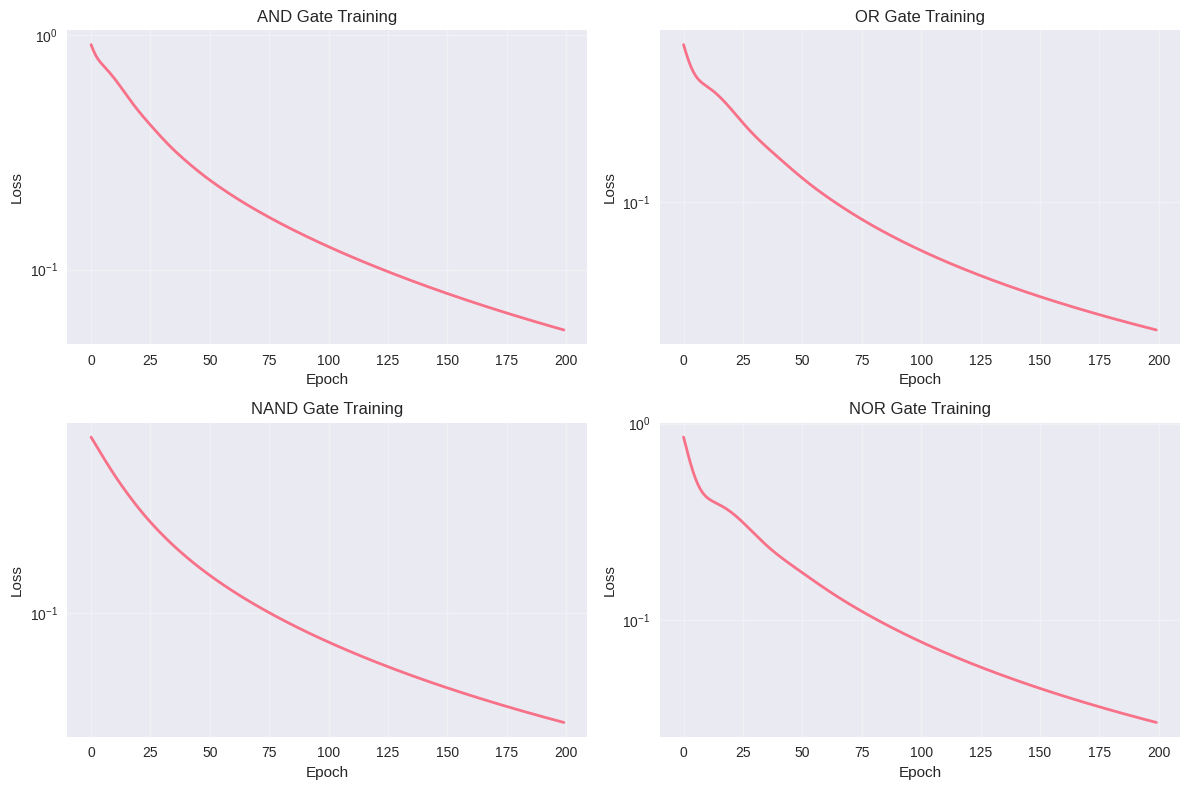

In [6]:
# Define all logic gates
gates_data = {
    'AND': torch.tensor([[0.0], [0.0], [0.0], [1.0]]),
    'OR':  torch.tensor([[0.0], [1.0], [1.0], [1.0]]),
    'NAND': torch.tensor([[1.0], [1.0], [1.0], [0.0]]),
    'NOR': torch.tensor([[1.0], [0.0], [0.0], [0.0]])
}

# Input data (same for all gates)
X_gates = torch.tensor([[0.0, 0.0],
                        [0.0, 1.0],
                        [1.0, 0.0],
                        [1.0, 1.0]])

# Train models for each gate
trained_models = {}
training_histories = {}

for gate_name, y_gate in gates_data.items():
    print(f"\nTraining {gate_name} gate...")

    # Create fresh model and optimizer
    model = SimplePerceptron(input_size=2)
    optimizer = optim.Adam(model.parameters(), lr=0.1)  # Using Adam optimizer
    criterion = nn.BCEWithLogitsLoss()

    losses = []

    # Training loop
    for epoch in range(200):
        optimizer.zero_grad()
        outputs = model(X_gates)
        loss = criterion(outputs, y_gate)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Early stopping if converged
        if loss.item() < 1e-4:
            print(f"  Converged after {epoch+1} epochs!")
            break

    # Store results
    trained_models[gate_name] = model
    training_histories[gate_name] = losses

    # Test the model
    with torch.no_grad():
        test_outputs = model(X_gates)
        predictions = torch.sigmoid(test_outputs) > 0.5
        accuracy = (predictions.float() == y_gate).float().mean()
        print(f"  Final accuracy: {accuracy:.1%}")

# Plot training histories
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (gate_name, losses) in enumerate(training_histories.items()):
    axes[i].plot(losses, linewidth=2)
    axes[i].set_title(f'{gate_name} Gate Training')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

## 7. Real-World Dataset with PyTorch

Training data: torch.Size([800, 10])
Test data: torch.Size([200, 10])
Features: 10
Classes: 2

Training on real-world dataset...
Epoch [20/100]
  Train Loss: 0.7362, Train Acc: 0.626
  Test Acc: 0.640
Epoch [40/100]
  Train Loss: 0.7036, Train Acc: 0.654
  Test Acc: 0.655
Epoch [60/100]
  Train Loss: 0.6663, Train Acc: 0.665
  Test Acc: 0.665
Epoch [80/100]
  Train Loss: 0.6583, Train Acc: 0.670
  Test Acc: 0.675
Epoch [100/100]
  Train Loss: 0.6270, Train Acc: 0.676
  Test Acc: 0.690


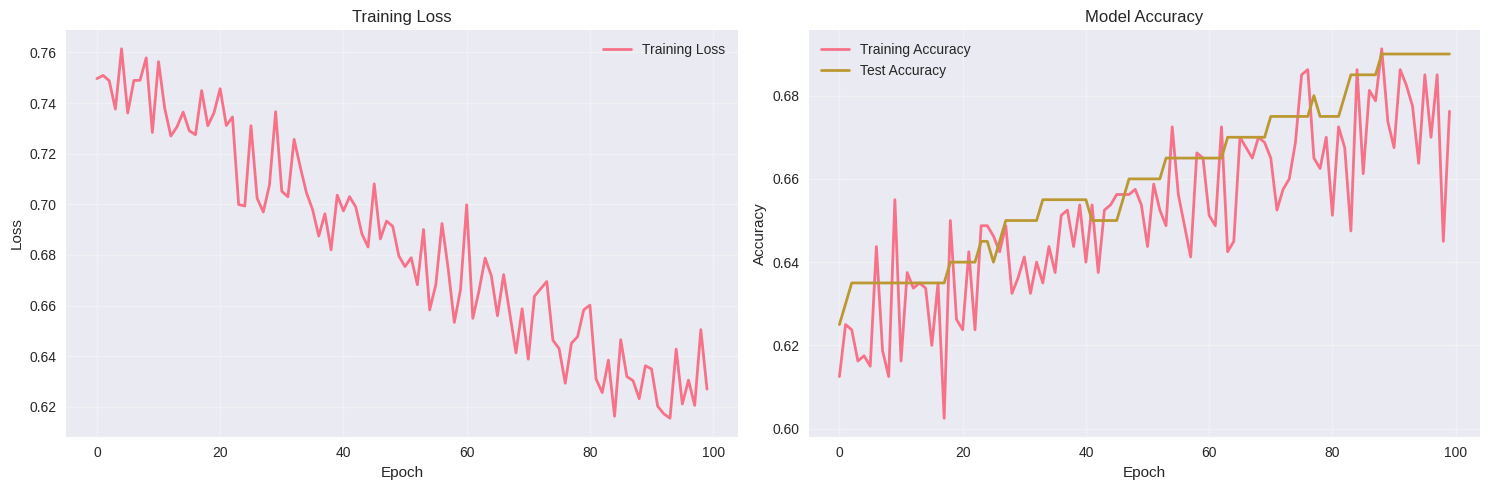


Final Results:
Training Accuracy: 0.676
Test Accuracy: 0.690


In [7]:
# Generate a larger, more complex dataset
X, y = make_classification(n_samples=1000,
                          n_features=10,
                          n_informative=5,
                          n_redundant=2,
                          n_clusters_per_class=1,
                          random_state=42)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

print(f"Training data: {X_train_tensor.shape}")
print(f"Test data: {X_test_tensor.shape}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

# Create a more sophisticated model
class RobustPerceptron(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(RobustPerceptron, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_size, 1)

        # Initialize weights with Xavier initialization
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

# Create model, loss, and optimizer
model = RobustPerceptron(input_size=X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training with validation
num_epochs = 100
train_losses = []
train_accuracies = []
test_accuracies = []

print("\nTraining on real-world dataset...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        train_predictions = torch.sigmoid(train_outputs) > 0.5
        train_accuracy = (train_predictions.float() == y_train_tensor).float().mean()

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = torch.sigmoid(test_outputs) > 0.5
        test_accuracy = (test_predictions.float() == y_test_tensor).float().mean()

    # Record metrics
    train_losses.append(train_loss.item())
    train_accuracies.append(train_accuracy.item())
    test_accuracies.append(test_accuracy.item())

    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {train_loss.item():.4f}, Train Acc: {train_accuracy:.3f}")
        print(f"  Test Acc: {test_accuracy:.3f}")

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, linewidth=2, label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Accuracy plot
ax2.plot(train_accuracies, linewidth=2, label='Training Accuracy')
ax2.plot(test_accuracies, linewidth=2, label='Test Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_accuracies[-1]:.3f}")
print(f"Test Accuracy: {test_accuracies[-1]:.3f}")

## 8. Model Inspection and Interpretation

Model Architecture:
RobustPerceptron(
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

Model Parameters:
linear.weight: torch.Size([1, 10])
  Min: -0.6321, Max: 0.6905
  Mean: 0.1048, Std: 0.4725
linear.bias: torch.Size([1])
  Value: -0.0436


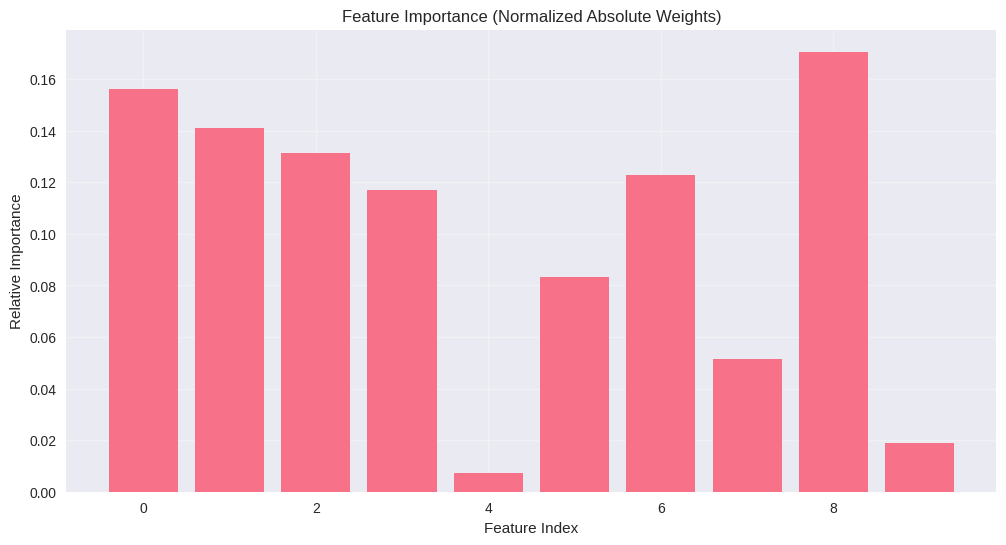


Model Complexity:
Total parameters: 11
Trainable parameters: 11
Model size: 0.04 KB (float32)


In [8]:
# Inspect the trained model
print("Model Architecture:")
print(model)

print("\nModel Parameters:")
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")
    if param.dim() == 1:  # bias
        print(f"  Value: {param.data.item():.4f}")
    else:  # weights
        print(f"  Min: {param.data.min():.4f}, Max: {param.data.max():.4f}")
        print(f"  Mean: {param.data.mean():.4f}, Std: {param.data.std():.4f}")

# Feature importance (absolute weights)
weights = model.linear.weight.data.abs().squeeze()
feature_importance = weights / weights.sum()

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance.numpy())
plt.title('Feature Importance (Normalized Absolute Weights)')
plt.xlabel('Feature Index')
plt.ylabel('Relative Importance')
plt.grid(True, alpha=0.3)
plt.show()

# Model complexity comparison
print("\nModel Complexity:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Model size: {total_params * 4 / 1024:.2f} KB (float32)")

## 9. Model Saving and Loading

In [9]:
# Save the trained model
model_path = 'perceptron_model.pth'

# Method 1: Save state dict (recommended)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Create a new model instance
loaded_model = RobustPerceptron(input_size=X.shape[1])

# Load the saved state dict
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

print("Model loaded successfully!")

# Verify that loaded model produces same results
with torch.no_grad():
    original_output = model(X_test_tensor[:5])
    loaded_output = loaded_model(X_test_tensor[:5])

    print("\nVerification (first 5 test samples):")
    print(f"Original model output: {original_output.squeeze().numpy()}")
    print(f"Loaded model output:   {loaded_output.squeeze().numpy()}")
    print(f"Difference: {(original_output - loaded_output).abs().max().item():.10f}")

# Method 2: Save entire model (for educational purposes)
torch.save(model, 'complete_model.pth')
complete_loaded_model = torch.load('complete_model.pth', weights_only=False)
print("\nComplete model saved and loaded as well!")

# Clean up files
import os
os.remove(model_path)
os.remove('complete_model.pth')
print("Temporary files cleaned up.")

Model saved to perceptron_model.pth
Model loaded successfully!

Verification (first 5 test samples):
Original model output: [-1.3188558   2.5147076   0.87200946 -2.319147    0.9954204 ]
Loaded model output:   [-1.3188558   2.5147076   0.87200946 -2.319147    0.9954204 ]
Difference: 0.0000000000

Complete model saved and loaded as well!
Temporary files cleaned up.


## 10. GPU Acceleration Demo

In [14]:
# Demonstrate GPU vs CPU performance (if GPU is available)
import time

# Create larger dataset for timing
large_X = torch.randn(10000, 100)
large_y = torch.randint(0, 2, (10000, 1)).float()

# CPU timing
cpu_model = SimplePerceptron(100)
cpu_model = cpu_model.to('cpu')
cpu_X = large_X.to('cpu')
cpu_y = large_y.to('cpu')

NPASSES = 2000

start_time = time.time()
for _ in range(NPASSES):
    output = cpu_model(cpu_X)
    loss = F.binary_cross_entropy_with_logits(output, cpu_y)
    loss.backward()
cpu_time = time.time() - start_time

print(f"CPU time for {NPASSES} forward+backward passes: {cpu_time:.4f}s")

# GPU timing (if available)
if torch.cuda.is_available():
    gpu_model = SimplePerceptron(100)
    gpu_model = gpu_model.to('cuda')
    gpu_X = large_X.to('cuda')
    gpu_y = large_y.to('cuda')

    # Warm up GPU
    for _ in range(5):
        _ = gpu_model(gpu_X)

    start_time = time.time()
    for _ in range(NPASSES):
        output = gpu_model(gpu_X)
        loss = F.binary_cross_entropy_with_logits(output, gpu_y)
        loss.backward()
    torch.cuda.synchronize()  # Wait for GPU to finish
    gpu_time = time.time() - start_time

    print(f"GPU time for {NPASSES} forward+backward passes: {gpu_time:.4f}s")
    print(f"Speedup: {cpu_time/gpu_time:.2f}x")
else:
    print("GPU not available for speed comparison")

# Memory usage
print(f"\nMemory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB" if torch.cuda.is_available() else "\nCPU mode - no GPU memory tracking")

CPU time for 2000 forward+backward passes: 1.8112s
GPU time for 2000 forward+backward passes: 1.0541s
Speedup: 1.72x

Memory allocated: 20.18 MB


## 11. Comparison: NumPy vs PyTorch

In [15]:
# Side-by-side comparison of NumPy and PyTorch implementations
print("NumPy vs PyTorch Comparison")
print("=" * 50)

comparison_table = """
| Aspect                | NumPy Implementation           | PyTorch Implementation         |
|----------------------|--------------------------------|--------------------------------|
| **Gradient Computation** | Manual derivative calculation  | Automatic differentiation      |
| **Optimization**     | Manual weight updates          | Built-in optimizers (SGD, Adam)|
| **Loss Functions**   | Manual implementation          | Pre-built functions            |
| **GPU Support**      | Not available                  | Seamless with .to('cuda')     |
| **Activation Functions** | Manual implementation      | Built-in functions             |
| **Model Saving**     | Custom serialization           | Built-in save/load             |
| **Scalability**      | Limited                        | Easy to extend to deep networks|
| **Learning Curve**   | Educational, shows details     | Production-ready              |
| **Lines of Code**    | ~100+ lines                    | ~20 lines                     |
"""

print(comparison_table)

# Code comparison
print("\nCode Comparison - Training Loop:")
print("-" * 30)

print("NumPy (manual):")
numpy_code = """
for epoch in range(epochs):
    # Forward pass
    z = np.dot(X, weights) + bias
    predictions = sigmoid(z)

    # Compute loss
    loss = -np.mean(y * np.log(predictions) + (1-y) * np.log(1-predictions))

    # Backward pass (manual gradients)
    dz = predictions - y
    dw = np.dot(X.T, dz) / len(X)
    db = np.mean(dz)

    # Update weights
    weights -= learning_rate * dw
    bias -= learning_rate * db
"""
print(numpy_code)

print("PyTorch (automatic):")
pytorch_code = """
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass (automatic gradients)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
"""
print(pytorch_code)

print("\nKey Advantages of PyTorch:")
advantages = [
    "✅ Automatic differentiation - no manual gradient calculation",
    "✅ Built-in optimizers with advanced features (momentum, learning rate scheduling)",
    "✅ GPU acceleration with minimal code changes",
    "✅ Extensive library of layers and functions",
    "✅ Easy to scale from simple perceptron to complex deep networks",
    "✅ Rich ecosystem and community support",
    "✅ Production-ready with deployment tools"
]

for advantage in advantages:
    print(f"  {advantage}")

NumPy vs PyTorch Comparison

| Aspect                | NumPy Implementation           | PyTorch Implementation         |
|----------------------|--------------------------------|--------------------------------|
| **Gradient Computation** | Manual derivative calculation  | Automatic differentiation      |
| **Optimization**     | Manual weight updates          | Built-in optimizers (SGD, Adam)|
| **Loss Functions**   | Manual implementation          | Pre-built functions            |
| **GPU Support**      | Not available                  | Seamless with .to('cuda')     |
| **Activation Functions** | Manual implementation      | Built-in functions             |
| **Model Saving**     | Custom serialization           | Built-in save/load             |
| **Scalability**      | Limited                        | Easy to extend to deep networks|
| **Learning Curve**   | Educational, shows details     | Production-ready              |
| **Lines of Code**    | ~100+ lines                    | 

## Summary and Next Steps

### What We've Learned:

1. **PyTorch Fundamentals**:
   - Tensors and automatic differentiation
   - Building models with `nn.Module`
   - Training loops with optimizers and loss functions

2. **Perceptron Implementation**:
   - Simple perceptron in just a few lines
   - Multiple activation functions
   - Batch training and validation

3. **Advanced Features**:
   - GPU acceleration
   - Model saving/loading
   - Feature importance analysis

### Key Advantages of PyTorch:

- **Simplicity**: Complex operations in just a few lines
- **Flexibility**: Easy to experiment and modify
- **Performance**: GPU acceleration and optimized operations
- **Scalability**: Same code works for simple perceptrons and complex networks
- **Community**: Extensive documentation and examples

### Next Steps:

1. **Deep Learning Fundamentals**:
   - Multi-layer perceptrons
   - Backpropagation in detail
   - Regularization techniques

2. **Advanced Architectures**:
   - Convolutional Neural Networks (CNNs)
   - Recurrent Neural Networks (RNNs)
   - Transformers

3. **Practical Applications**:
   - Computer vision
   - Natural language processing
   - Time series analysis

### Resources for Further Learning:

- [PyTorch Official Tutorials](https://pytorch.org/tutorials/)
- [Deep Learning with PyTorch](https://pytorch.org/deep-learning-with-pytorch)
- [PyTorch Documentation](https://pytorch.org/docs/)

**Congratulations on completing your journey from NumPy to PyTorch! 🚀**